<a href="https://colab.research.google.com/github/lucho19jose/COVID-Detection-DenseNet201/blob/main/COVID_nnpythorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import Tensor

import matplotlib.pyplot as plt
import time   
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil
#
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision.models as models

import sys
import math
from enum import Enum
from collections import OrderedDict


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [ ]:
pathfolder = '/content/drive/MyDrive/DeepLearning'

In [ ]:
df = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
selected_df = df[df.finding=="Pneumonia/Viral/COVID-19"]
selected_df = selected_df[(selected_df.view == "AP") | (selected_df.view == "PA")]
print(selected_df.head(2))
len(selected_df)

  patientid  offset sex   age                   finding RT_PCR_positive  \
0         2     0.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
1         2     3.0   M  65.0  Pneumonia/Viral/COVID-19               Y   

  survival intubated intubation_present went_icu  ...              date  \
0        Y         N                  N        N  ...  January 22, 2020   
1        Y         N                  N        N  ...  January 25, 2020   

                                      location  folder  \
0  Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
1  Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   

                                            filename                   doi  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   

                                                 url  license  \
0  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
1  https

342

In [ ]:
images = selected_df.filename.values.tolist()
print("covid imgs", len(images))

covid imgs 342


In [ ]:
#os.makedirs(pathfolder + '/COVID19-DATASET/train/covid19') 
#os.makedirs(pathfolder + '/COVID19-DATASET/train/normal')


In [ ]:
COVID_PATH = pathfolder + '/COVID19-DATASET/train/covid19'
NORMAL_PATH = pathfolder + '/COVID19-DATASET/train/normal'

In [ ]:
#for image in images:
#    shutil.copy(os.path.join('./covid-chestxray-dataset/images', image), os.path.join(COVID_PATH, image))#copy data from github to covidpath 

#for image in os.listdir(pathfolder + '/chest_xray/train/NORMAL')[:300]: # normal from the another dataset that is stored in drive
#    shutil.copy(os.path.join(pathfolder + '/chest_xray/train/NORMAL', image), os.path.join(NORMAL_PATH, image))


In [ ]:
''' for image in os.listdir('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/COVID/images')[:150]:
    shutil.copy(os.path.join('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/COVID/images', image), os.path.join(COVID_PATH, image))
for image in os.listdir('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/Normal/images')[:150]:
    shutil.copy(os.path.join('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/Normal/images', image), os.path.join(NORMAL_PATH, image)) '''

" for image in os.listdir('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/COVID/images')[:150]:\n    shutil.copy(os.path.join('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/COVID/images', image), os.path.join(COVID_PATH, image))\nfor image in os.listdir('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/Normal/images')[:150]:\n    shutil.copy(os.path.join('/content/drive/MyDrive/DeepLearning/COVID-19_Radiography_Dataset/Normal/images', image), os.path.join(NORMAL_PATH, image)) "

In [ ]:
print(len(os.listdir(pathfolder + '/COVID19-DATASET/train/normal')))
print(len(os.listdir(pathfolder + '/COVID19-DATASET/train/covid19')))

300
342


In [ ]:
DATA_PATH = pathfolder + '/COVID19-DATASET/train'
DATA_PATH

'/content/drive/MyDrive/DeepLearning/COVID19-DATASET/train'

['covid19', 'normal']
342
300


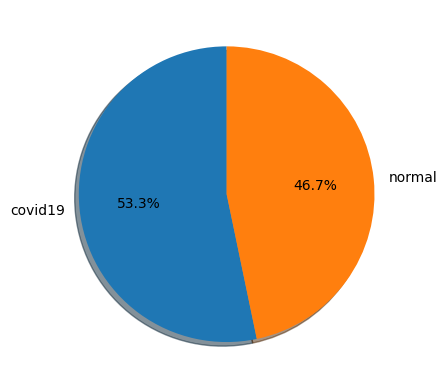

In [ ]:
class_names = os.listdir(DATA_PATH)
print(class_names)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) #/content/drive/MyDrive/DeepLearning/COVID19-DATASET/train/ -> i = covid19 and normal
    print(len(os.listdir(os.path.join(DATA_PATH,i))))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

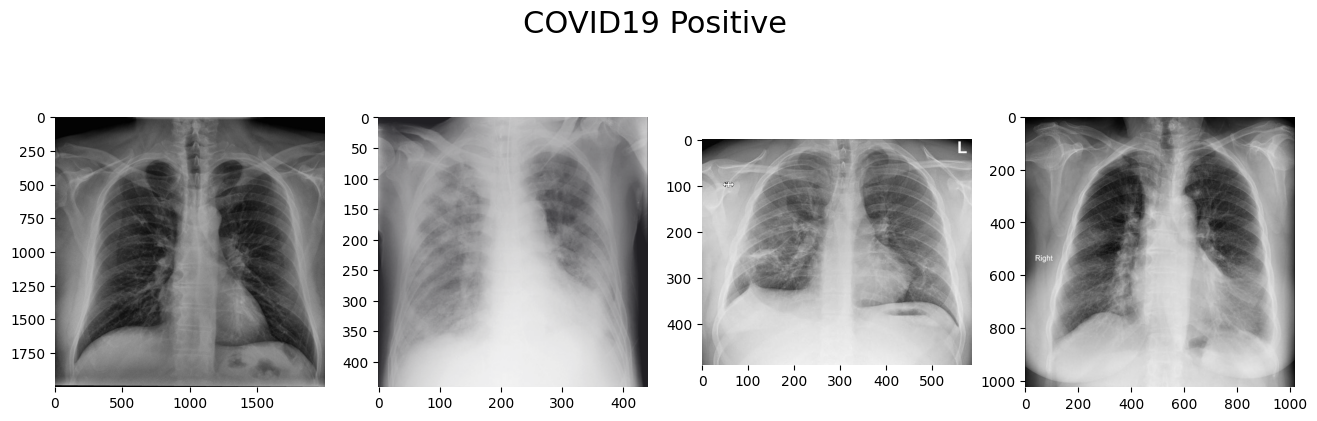

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)# to show 4 random imgs

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

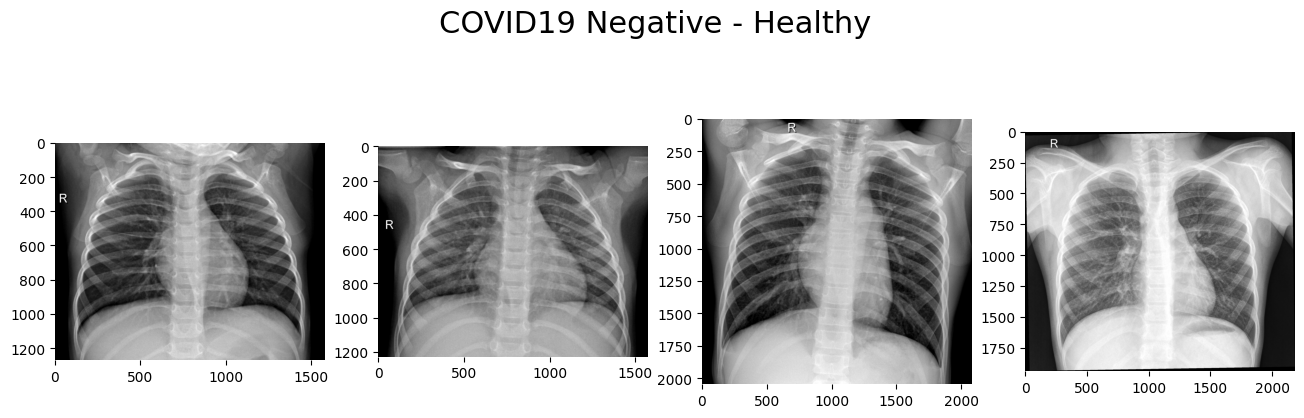

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406] # a common practice when uses imagenet pytorch
std_nums = [0.229, 0.224, 0.225] # desviacion estandar

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension -> imagenes 150
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images ->probar
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}
print(data_transforms)

{'train': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.4)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(150, 150))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    print(train_data)
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    print(test_data)
    num_train = len(train_data)
    num_test = len(test_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, #Combines a dataset and a sampler, and provides an iterable over the given dataset
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches 8
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(data_sizes)

Dataset ImageFolder
    Number of datapoints: 642
    Root location: /content/drive/MyDrive/DeepLearning/COVID19-DATASET/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.4)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 642
    Root location: /content/drive/MyDrive/DeepLearning/COVID19-DATASET/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(150, 150))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'train': 514, 'val': 128}


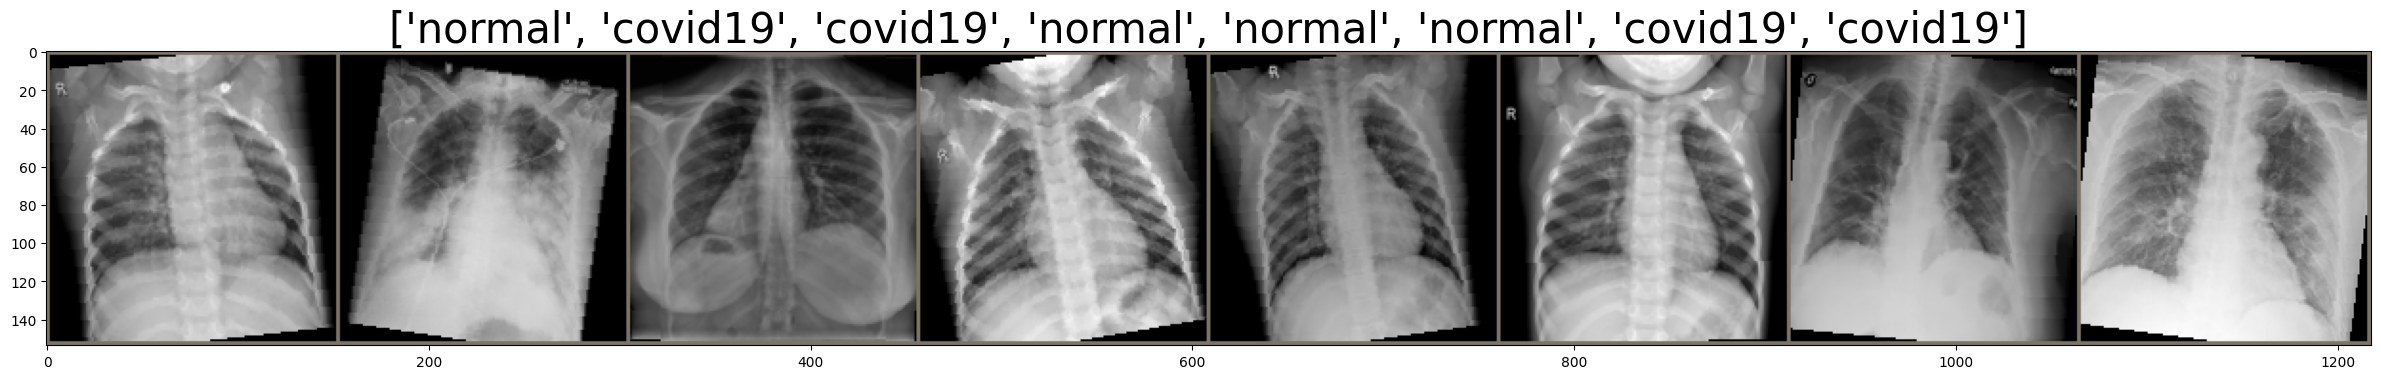

In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated

print(dataloaders['train'])
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [ ]:
torch.cuda.empty_cache()

In [ ]:
''' from torchvision.models import DenseNet121_Weights, DenseNet161_Weights, DenseNet169_Weights, DenseNet201_Weights
def CNN_Model(pretrained=True):
    model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1) # Returns Defined Densenet model with weights trained on ImageNet - mobilenet - tabla
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model  '''

#model = CNN_Model(pretrained=True)

## specify loss function (categorical cross-entropy loss)
#criterion = nn.CrossEntropyLoss() 

## Specify optimizer which performs Gradient Descent
#optimizer = optim.Adam(model.parameters(), lr=1e-3) # optim.SGD aswell
## Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler - Decays the learning rate of each parameter group


' from torchvision.models import DenseNet121_Weights, DenseNet161_Weights, DenseNet169_Weights, DenseNet201_Weights\ndef CNN_Model(pretrained=True):\n    model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1) # Returns Defined Densenet model with weights trained on ImageNet - mobilenet - tabla\n    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer\n    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning\n    model = model.to(device) # Transfer the Model to GPU if available\n    return model  '

In [ ]:
#pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#print("Number of trainable parameters: \n{}".format(pytorch_total_params))



# 6955906

In [ ]:
!cp /content/drive/MyDrive/DeepLearning/_api.py /content
!cp /content/drive/MyDrive/DeepLearning/_utils.py /content
!cp /content/drive/MyDrive/DeepLearning/_presets.py /content
!cp /content/drive/MyDrive/DeepLearning/_meta.py /content
!cp /content/drive/MyDrive/DeepLearning/_internally_replaced_utils.py /content


In [ ]:
!ls

_api.py			 _internally_replaced_utils.py	__pycache__
covid-chestxray-dataset  _meta.py			sample_data
drive			 _presets.py			_utils.py


In [ ]:
from _api import Weights, WeightsEnum
from _utils import _ovewrite_named_param
from _presets import ImageClassification
from _meta import _IMAGENET_CATEGORIES

In [ ]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


In [ ]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.MaxPool2d(kernel_size=3, stride=2))# AvgPool2d stride 2

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        "Bottleneck function"
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)#why
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size, #bn_size parameter determines the number of output channels after the bottleneck operation.
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=2, memory_efficient=False, ):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=2, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
def _load_state_dict(model: nn.Module, weights: WeightsEnum, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r"^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$"
    )

    state_dict = weights.get_state_dict(progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

In [ ]:
_COMMON_META = {
    "min_size": (29, 29),
    "categories": _IMAGENET_CATEGORIES,
    "recipe": "https://github.com/pytorch/vision/pull/116",
    "_docs": """These weights are ported from LuaTorch.""",
}

class DenseNet201_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/densenet201-c1103571.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 20013928,
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 76.896,
                    "acc@5": 93.370,
                }
            },
            "_ops": 4.291,
            "_file_size": 77.373,
        },
    )
    DEFAULT = IMAGENET1K_V1
    
def _densenet(arch, growth_rate, block_config, num_init_features, weights: Optional[WeightsEnum], pretrained, progress,
              **kwargs):
    if weights is not None:
      _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)

    if weights is not None:
      _load_state_dict(model=model, weights=weights, progress=progress)
    model.classifier = nn.Linear(model.classifier.in_features, 2)
    
    return model

def densenet201(weights: Optional[DenseNet201_Weights] = None, pretrained=False, progress=True, **kwargs):
    weights = DenseNet201_Weights.verify(weights)
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, weights, pretrained, progress,# 6, 12, 24, 16
                     **kwargs)

In [ ]:
model = densenet201(weights='IMAGENET1K_V1')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss() 
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"the counter value is {self.counter}")
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
early_stopper = EarlyStopper(patience=10, min_delta=0)
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()
            
            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)# returns array max values ->indices  
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() #Computes the gradient of current tensor
                        optimizer.step() #A closure that reevaluates the model and returns the loss
                
                if phase == 'train':
                    scheduler.step() #If you don’t call it, the learning rate won’t be changed and stays at the initial value

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        if early_stopper.early_stop(epoch_loss):# applying early stopping              
          pass#break 

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                print(labels[j].item())
                print(preds[j])
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 1/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.3000 | train Accuracy: 0.8735


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1590 | val Accuracy: 0.9453 | Kappa Score: 0.8812
Val loss Decreased from inf to 0.1590 
Saving Weights... 
Epoch 2/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2838 | train Accuracy: 0.8911


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1969 | val Accuracy: 0.9297 | Kappa Score: 0.8433
the counter value is 1
Epoch 3/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2205 | train Accuracy: 0.9125


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2322 | val Accuracy: 0.9219 | Kappa Score: 0.8121
the counter value is 2
Epoch 4/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2530 | train Accuracy: 0.8988


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.0864 | val Accuracy: 0.9844 | Kappa Score: 0.9665
Val loss Decreased from 0.1590 to 0.0864 
Saving Weights... 
Epoch 5/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1939 | train Accuracy: 0.9163


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2201 | val Accuracy: 0.9297 | Kappa Score: 0.8455
the counter value is 1
Epoch 6/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2160 | train Accuracy: 0.9125


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1169 | val Accuracy: 0.9609 | Kappa Score: 0.9219
the counter value is 2
Epoch 7/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1805 | train Accuracy: 0.9222


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1107 | val Accuracy: 0.9766 | Kappa Score: 0.9509
the counter value is 3
Epoch 8/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2917 | train Accuracy: 0.8774


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1130 | val Accuracy: 0.9688 | Kappa Score: 0.9353
the counter value is 4
Epoch 9/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2331 | train Accuracy: 0.9086


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1912 | val Accuracy: 0.9375 | Kappa Score: 0.8683
the counter value is 5
Epoch 10/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1877 | train Accuracy: 0.9377


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2007 | val Accuracy: 0.9453 | Kappa Score: 0.8858
the counter value is 6
Epoch 11/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2793 | train Accuracy: 0.8794


val:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.1115 | val Accuracy: 0.9688 | Kappa Score: nan
the counter value is 7
Epoch 12/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2020 | train Accuracy: 0.9222


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2263 | val Accuracy: 0.9297 | Kappa Score: 0.8478
the counter value is 8
Epoch 13/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2325 | train Accuracy: 0.9105


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2888 | val Accuracy: 0.8672 | Kappa Score: 0.7130
the counter value is 9
Epoch 14/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2298 | train Accuracy: 0.9144


val:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.2307 | val Accuracy: 0.9219 | Kappa Score: nan
the counter value is 10
Epoch 15/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2094 | train Accuracy: 0.9105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.1247 | val Accuracy: 0.9609 | Kappa Score: nan
the counter value is 11
Epoch 16/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2393 | train Accuracy: 0.9066


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1503 | val Accuracy: 0.9531 | Kappa Score: 0.8987
the counter value is 12
Epoch 17/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2029 | train Accuracy: 0.9105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1159 | val Accuracy: 0.9609 | Kappa Score: 0.9031
the counter value is 13
Epoch 18/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1949 | train Accuracy: 0.9222


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1093 | val Accuracy: 0.9688 | Kappa Score: 0.9165
the counter value is 14
Epoch 19/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2060 | train Accuracy: 0.9125


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1990 | val Accuracy: 0.9453 | Kappa Score: 0.8884
the counter value is 15
Epoch 20/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2499 | train Accuracy: 0.8891


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2137 | val Accuracy: 0.9297 | Kappa Score: 0.8353
the counter value is 16
Epoch 21/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2314 | train Accuracy: 0.9105


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2026 | val Accuracy: 0.9375 | Kappa Score: 0.8612
the counter value is 17
Epoch 22/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1953 | train Accuracy: 0.9222


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1664 | val Accuracy: 0.9453 | Kappa Score: 0.8696
the counter value is 18
Epoch 23/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.3025 | train Accuracy: 0.8852


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1896 | val Accuracy: 0.9375 | Kappa Score: 0.8567
the counter value is 19
Epoch 24/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1895 | train Accuracy: 0.9144


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1394 | val Accuracy: 0.9609 | Kappa Score: 0.9152
the counter value is 20
Epoch 25/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2279 | train Accuracy: 0.9125


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1431 | val Accuracy: 0.9531 | Kappa Score: 0.8996
the counter value is 21
Epoch 26/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1893 | train Accuracy: 0.9163


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1660 | val Accuracy: 0.9453 | Kappa Score: 0.8789
the counter value is 22
Epoch 27/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1950 | train Accuracy: 0.9202


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2902 | val Accuracy: 0.8672 | Kappa Score: 0.7003
the counter value is 23
Epoch 28/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2531 | train Accuracy: 0.8988


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2091 | val Accuracy: 0.9375 | Kappa Score: 0.8652
the counter value is 24
Epoch 29/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2719 | train Accuracy: 0.8930


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1043 | val Accuracy: 0.9766 | Kappa Score: 0.9040
the counter value is 25
Epoch 30/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2401 | train Accuracy: 0.9086


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.0814 | val Accuracy: 0.9922 | Kappa Score: 0.9844
Val loss Decreased from 0.0864 to 0.0814 
Saving Weights... 
Epoch 31/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2316 | train Accuracy: 0.9047


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1784 | val Accuracy: 0.9453 | Kappa Score: 0.8839
the counter value is 1
Epoch 32/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2386 | train Accuracy: 0.8891


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1370 | val Accuracy: 0.9531 | Kappa Score: 0.8853
the counter value is 2
Epoch 33/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2083 | train Accuracy: 0.9105


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1956 | val Accuracy: 0.9375 | Kappa Score: 0.8446
the counter value is 3
Epoch 34/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2226 | train Accuracy: 0.9183


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1567 | val Accuracy: 0.9453 | Kappa Score: 0.8839
the counter value is 4
Epoch 35/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2182 | train Accuracy: 0.9047


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1682 | val Accuracy: 0.9453 | Kappa Score: 0.8456
the counter value is 5
Epoch 36/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2101 | train Accuracy: 0.9125


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1574 | val Accuracy: 0.9453 | Kappa Score: 0.8925
the counter value is 6
Epoch 37/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2031 | train Accuracy: 0.9144


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1437 | val Accuracy: 0.9453 | Kappa Score: 0.8746
the counter value is 7
Epoch 38/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2402 | train Accuracy: 0.8930


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.3025 | val Accuracy: 0.8594 | Kappa Score: 0.6236
the counter value is 8
Epoch 39/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2654 | train Accuracy: 0.9008


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1607 | val Accuracy: 0.9453 | Kappa Score: 0.8880
the counter value is 9
Epoch 40/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2369 | train Accuracy: 0.9066


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1713 | val Accuracy: 0.9453 | Kappa Score: 0.8902
the counter value is 10
Epoch 41/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2389 | train Accuracy: 0.8949


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1479 | val Accuracy: 0.9531 | Kappa Score: 0.8830
the counter value is 11
Epoch 42/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2040 | train Accuracy: 0.9202


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.2404 | val Accuracy: 0.9062 | Kappa Score: 0.8169
the counter value is 12
Epoch 43/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2160 | train Accuracy: 0.9163


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1992 | val Accuracy: 0.9375 | Kappa Score: 0.8683
the counter value is 13
Epoch 44/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2556 | train Accuracy: 0.8949


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1477 | val Accuracy: 0.9531 | Kappa Score: 0.8969
the counter value is 14
Epoch 45/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1821 | train Accuracy: 0.9261


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1953 | val Accuracy: 0.9453 | Kappa Score: 0.8862
the counter value is 15
Epoch 46/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2087 | train Accuracy: 0.9125


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1510 | val Accuracy: 0.9531 | Kappa Score: 0.8924
the counter value is 16
Epoch 47/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1716 | train Accuracy: 0.9222


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1319 | val Accuracy: 0.9531 | Kappa Score: 0.9018
the counter value is 17
Epoch 48/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.1951 | train Accuracy: 0.9319


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.1113 | val Accuracy: 0.9766 | Kappa Score: nan
the counter value is 18
Epoch 49/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2500 | train Accuracy: 0.9008


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1865 | val Accuracy: 0.9453 | Kappa Score: 0.8858
the counter value is 19
Epoch 50/50
----------


train:   0%|          | 0/65 [00:00<?, ?it/s]

train Loss: 0.2369 | train Accuracy: 0.9047


val:   0%|          | 0/16 [00:00<?, ?it/s]

val Loss: 0.1630 | val Accuracy: 0.9453 | Kappa Score: 0.8718
the counter value is 20
Training complete in 30m 34s
Best val loss: 0.0814


In [ ]:
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info
# https://github.com/sovrasov/flops-counter.pytorch
# https://github.com/sovrasov/flops-counter.pytorch/issues/16 -> GFLOPs = 2 * GMACs

with torch.cuda.device(0):
  #net = models.densenet161()
  macs, params = get_model_complexity_info(model, (3, 150, 150), as_strings=True,#224 224 instead 50
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

DenseNet(
  18.1 M, 100.000% Params, 1.62 GMac, 100.000% MACs, 
  (features): Sequential(
    18.09 M, 99.979% Params, 1.62 GMac, 100.000% MACs, 
    (conv0): Conv2d(9.41 k, 0.052% Params, 52.92 MMac, 3.270% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(128, 0.001% Params, 720.0 KMac, 0.044% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(0, 0.000% Params, 360.0 KMac, 0.022% MACs, inplace=True)
    (pool0): MaxPool2d(0, 0.000% Params, 360.0 KMac, 0.022% MACs, kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      335.04 k, 1.851% Params, 486.15 MMac, 30.040% MACs, 
      (denselayer1): _DenseLayer(
        45.44 k, 0.251% Params, 65.89 MMac, 4.072% MACs, 
        (norm1): BatchNorm2d(128, 0.001% Params, 184.83 KMac, 0.011% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(0, 0.000% Params, 92.42 

1
tensor(1, device='cuda:0')


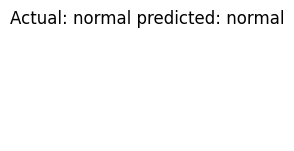

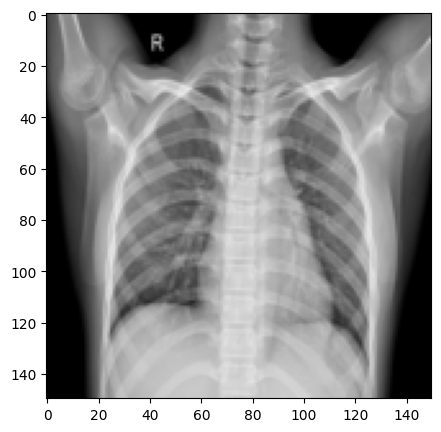

1
tensor(1, device='cuda:0')


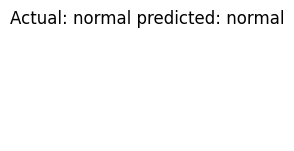

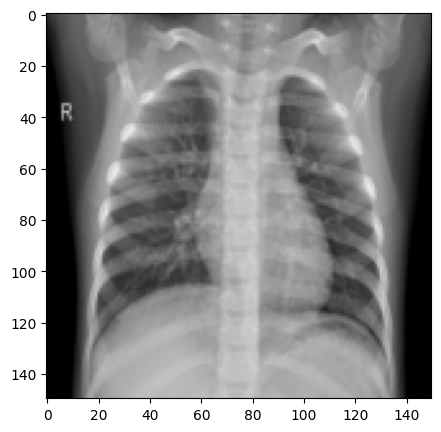

1
tensor(1, device='cuda:0')


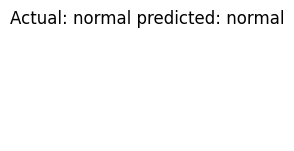

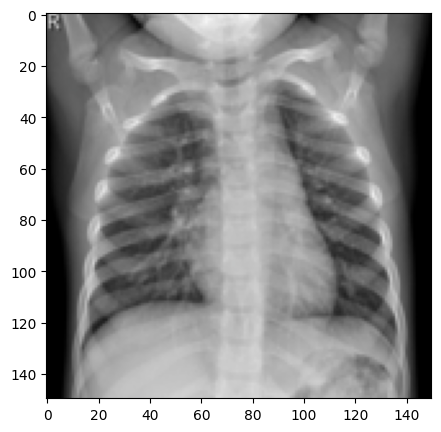

1
tensor(1, device='cuda:0')


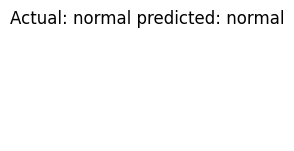

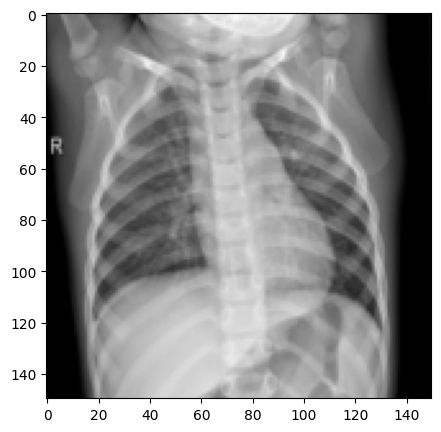

0
tensor(0, device='cuda:0')


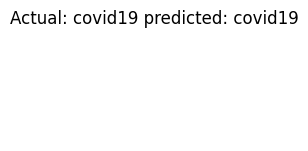

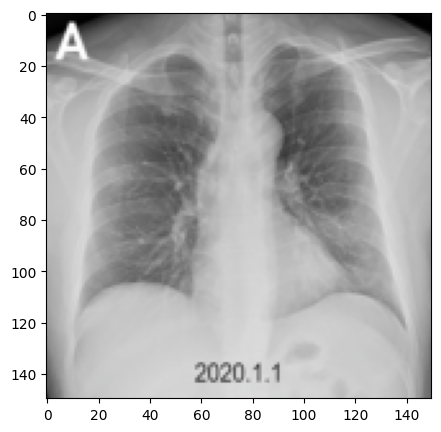

1
tensor(1, device='cuda:0')


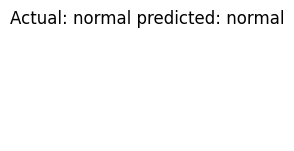

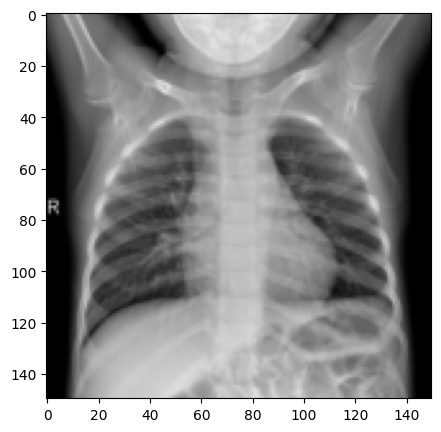

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
#os.makedirs(pathfolder + '/COVID19-DATASET4/test/covid19')
#os.makedirs(pathfolder + '/COVID19-DATASET4/test/normal')

In [ ]:
!ls

_api.py			 _internally_replaced_utils.py	__pycache__
covid-chestxray-dataset  _meta.py			sample_data
drive			 _presets.py			_utils.py


In [ ]:
COVID_TEST = pathfolder + '/COVID-19_Radiography_Dataset/COVID/images'
NORMAL_TEST = pathfolder + '/COVID-19_Radiography_Dataset/Normal/images' #'/COVID-19_Radiography_Dataset/Normal/images'
NORMAL_TEST = pathfolder + '/COVID-19_Radiography_Dataset/Normal/images' #'/COVID-19_Radiography_Dataset/Normal/images'

''' for image in os.listdir(COVID_TEST)[:200]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join(pathfolder + '/COVID19-DATASET4/test/covid19', image)) '''
''' for image in os.listdir(NORMAL_TEST)[:200]:
   shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join(pathfolder + '/COVID19-DATASET4/test/normal', image))
 '''
''' for image in os.listdir(pathfolder + '/chest_xray/test/NORMAL')[:200]: # normal from the another dataset that is stored in drive
    shutil.copy(os.path.join(pathfolder + '/chest_xray/test/NORMAL', image), os.path.join(pathfolder + '/COVID19-DATASET4/test/normal', image))
 '''
#print(len(os.listdir(COVID_TEST)[:100]))
#print(len(os.listdir(NORMAL_TEST)[:100]))

''' counter = 0
for image in os.listdir(pathfolder + '/chest_xray/train/NORMAL')[300:400]: # normal from the another dataset that is stored in drive
    shutil.copy(os.path.join(pathfolder + '/chest_xray/train/NORMAL', image), os.path.join(pathfolder + '/COVID19-DATASET/test/normal', image))
    counter += 1;
    print(image)
print(counter) '''

''' counter = 0
for image in os.listdir(pathfolder + '/chest_xray/test/NORMAL')[100:200]: # normal from the another dataset that is stored in drive
    shutil.copy(os.path.join(pathfolder + '/chest_xray/test/NORMAL', image), os.path.join(pathfolder + '/COVID19-DATASET/test/normal', image))
    counter += 1;
    print(image)
print(counter) '''

" counter = 0\nfor image in os.listdir(pathfolder + '/chest_xray/test/NORMAL')[100:200]: # normal from the another dataset that is stored in drive\n    shutil.copy(os.path.join(pathfolder + '/chest_xray/test/NORMAL', image), os.path.join(pathfolder + '/COVID19-DATASET/test/normal', image))\n    counter += 1;\n    print(image)\nprint(counter) "

In [ ]:
TEST_DATA_PATH = pathfolder + '/COVID19-DATASET/test/'#COVID19-DATASET/test/

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=4)#batch_size 1

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)#dim=1
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
y_pred_list

[array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 1]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([1, 0, 0, 1]),
 array([0, 0, 1, 0]),
 array([1, 0, 1, 1]),
 array([1, 0, 0, 1]),
 array([1, 1, 0, 1]),
 array([1, 0, 1, 1]),
 array([1, 1, 1, 0]),
 array([1, 0, 1, 1]),
 array([1, 0, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 0]),
 array([1, 1, 1, 1]),
 array([1, 1, 0, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1,

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]# i[0] instead i 
y_true_list = [i[0] for i in y_true_list]# i[0] instead i 

print(y_pred_list)
print(y_true_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.96      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

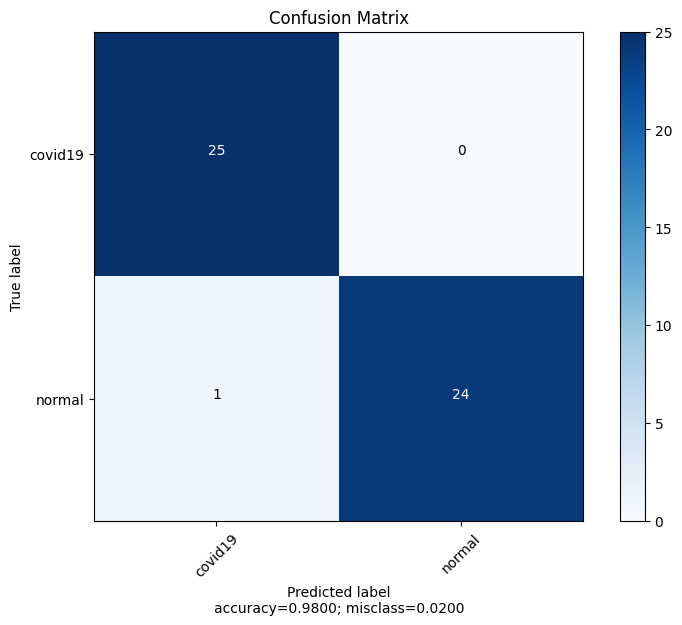

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [ ]:
#torch.save(base_model.state_dict(), './best_model.pth')

In [ ]:
# check image size that could be the reason to get lower than 90 accuracy 